<a href="https://colab.research.google.com/github/OmdenaAI/ladakh-india-glacier-mapping/blob/main/src/visualizations/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
#pip install folium
#pip install earthengine-api #if running on local conda environment
# initiate earthengine authenticate to start the process in the local conda environment
###only needed the first time your run

#ee.Authenticate() #-----IMPORTANT

In [46]:
# Import necessary libraries
import ee
import folium
from glob import glob
import geopandas as gpd
import pandas as pd


In [47]:
# Initialize the Earth Engine API
ee.Initialize()

# Define a method to display Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [48]:
# Set the area of interest (AOI). For our example, it will be a rectangle around Ladakh
aoi = ee.Geometry.Rectangle([75.0, 36, 82, 32])

# Load a landsat image. Filter by date and AOI and cloud cover.
landsat = (ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA')
           .filterDate(ee.Date('2020-07-01'), ee.Date('2020-10-31'))
           .filterBounds(aoi)
            .filterMetadata('CLOUD_COVER', 'less_than', 10)
           .median())  # Take the median to remove clouds


# this was the process that was mentioned in one of the tutorials
# Use normalized difference to emphasize water bodies which can be indicative of glacial melt.
ndwi = landsat.normalizedDifference(['B3', 'B6'])

# Threshold the NDWI to create a binary mask of potential glacier locations.
glacier_mask = ndwi.gt(0.3)

In [49]:
# Visualize
location = [34.0, 77.5]  # For ladakh regions just a point somehwere in the rectangle
m = folium.Map(location=location, zoom_start=7)

# Define the bounds of the rectangle. Format: [[lat_min, lon_min], [lat_max, lon_max]]
bounds = [[75, 36], [82, 32]]

# Add the rectangle to the map
folium.Rectangle(
    bounds=bounds,
    color='#ff7800',
    fill=True,
    fill_color='#ffff00',
    fill_opacity=0.2
).add_to(m)

# Add the raw image to the map
vis_params = {'bands': ['B4', 'B3', 'B2'], 'max': 0.3}
m.add_ee_layer(landsat, vis_params, 'Landsat Image')

# Add the glacier mask to the map
m.add_ee_layer(glacier_mask.updateMask(glacier_mask), {'palette': 'blue'}, 'Glacier Mask')

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

In [50]:
# Visualize without glacier mask
location = [34.0, 77.5]  # For ladakh regions just a point somehwere in the rectangle
m = folium.Map(location=location, zoom_start=7)

# Define the bounds of the rectangle. Format: [[lat_min, lon_min], [lat_max, lon_max]]
bounds = [[75, 36], [82, 32]]

# Add the rectangle to the map
folium.Rectangle(
    bounds=bounds,
    color='#ff7800',
    fill=True,
    fill_color='#ffff00',
    fill_opacity=0.2
).add_to(m)



# Add the raw image to the map
vis_params = {'bands': ['B4', 'B3', 'B2'], 'max': 0.3}
m.add_ee_layer(landsat, vis_params, 'Landsat Image')

# Add the glacier mask to the map
#m.add_ee_layer(glacier_mask.updateMask(glacier_mask), {'palette': 'blue'}, 'Glacier Mask')


    
# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

In [51]:
# Reading in Pangong glacier data for 1977
gdf = gpd.read_file('/Users/butler/Documents/hp/Ladakh/data/DATA_IN_GEOPACKAGE_FORMAT/GLACIER_OUTLINES/PANGONG_GLACIERS_2019.gpkg')
gdf.head()


JNUOAId           RGIId         GLIMSId     CenLon     CenLat  Zmax  Zmean  \
0     PG1  RGI60-13.04777  G078647E33431N  78.642911  33.430580  6099   5942   
1     PG2  RGI60-13.04778  G078698E33412N  78.698097  33.412155  6035   5904   
2     PG3  RGI60-13.04788  G078699E33362N  78.714487  33.354976  6128   5827   
3     PG4  RGI60-13.04795  G078731E33340N  78.731849  33.339669  6074   5837   
4     PG5  RGI60-13.04798  G078721E33885N  78.720581  33.884435  6225   5875   

   Zmin  MeanAspect  MeanSlope      Area      Lmax    U_Area    U_Lmax  \
0  5787         353       25.0  0.606668  1.173682  0.017600  0.017605   
1  5719         347       12.0  1.062716  1.912953  0.018115  0.028694   
2  5600         344       13.0  2.471055  2.715811  0.033686  0.040737   
3  5664         346       20.0  0.511051  1.344401  0.012965  0.020166   
4  5639         354       24.0  0.671652  1.543407  0.015683  0.023151   

                                            geometry  
0  MULTIPOLYGON (((839299.958 3704977.405, 839302...  
1  MULTIPOLYGON (((843929.592 3703790.798, 843952...  
2  MULTIPOLYGON (((845295.971 3698008.443, 845318...  
3  MULTIPOLYGON (((847750.440 3695790.073, 847751...  
4  MULTIPOLYGON (((844012.922 3756386.324, 844033...

In [52]:
gdf.shape

(190, 15)

In [53]:
gdf['area'] = gdf.area

In [54]:
gdf = gdf.to_crs(epsg=4326)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

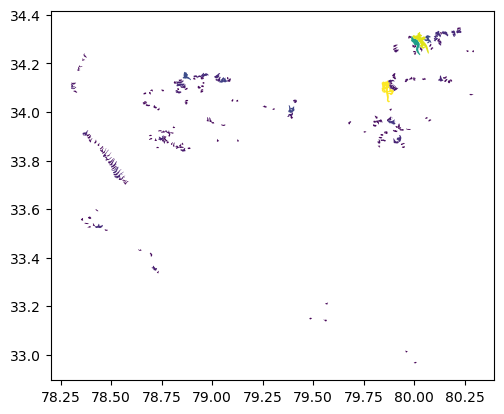

In [55]:
gdf.plot('area')

In [56]:
# Reading in Shayok glacier data for 1977
gdf1 = gpd.read_file('/Users/butler/Documents/hp/Ladakh/data/DATA_IN_GEOPACKAGE_FORMAT/GLACIER_OUTLINES/SHAYOK_GLACIERS_2019.gpkg')

In [57]:
gdf1.head()

JNUOAId           RGIId         GLIMSId     CenLon     CenLat  Zmax  Zmean  \
0     SH1  RGI60-14.05890  G077428E35296N  77.426422  35.441423  6735   5682   
1     SH2  RGI60-14.05890  G077428E35296N  77.466888  35.326932  7185   5636   
2     SH3  RGI60-14.07524  G076894E35428N  77.127898  35.284234  5975   5476   
3     SH4  RGI60-14.05890  G077428E35296N  77.345828  35.303098  6846   5485   
4     SH5  RGI60-14.07779  G077294E35212N  77.300144  35.213109  5991   5462   

   Zmin  MeanAspect  MeanSlope        Area       Lmax    U_Area    U_Lmax  \
0  4993          94        8.0  213.658653  42.013713  1.187118  0.630206   
1  4970          66       12.0  155.586575  23.154289  1.136624  0.347314   
2  5155         179       19.0    0.853255   2.367143  0.028256  0.035507   
3  3975         216       16.0   89.474485  20.862702  1.062182  0.312941   
4  4618          33       18.0    4.766370   5.714494  0.080365  0.085717   

                                            geometry  
0  MULTIPOLYGON (((724214.933 3918367.741, 724220...  
1  MULTIPOLYGON (((723038.038 3905882.963, 723014...  
2  MULTIPOLYGON (((693244.497 3907315.002, 693311...  
3  MULTIPOLYGON (((714532.859 3907485.004, 714494...  
4  MULTIPOLYGON (((710805.892 3901835.982, 710640...

In [58]:
gdf1.shape

(1262, 15)

In [59]:
gdf1['area'] = gdf1.area

In [60]:
gdf1 = gdf1.to_crs(epsg=4326)
gdf1.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

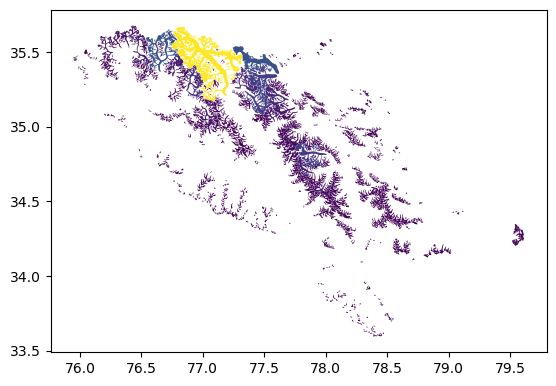

In [61]:
gdf1.plot('area')

In [62]:
# Reading in Leh glacier data for 1977
gdf2 = gpd.read_file('/Users/butler/Documents/hp/Ladakh/data/DATA_IN_GEOPACKAGE_FORMAT/GLACIER_OUTLINES/LEH_GLACIERS_2019.gpkg')

In [63]:
gdf2['area'] = gdf2.area

In [64]:
gdf2 = gdf2.to_crs(epsg=4326)
gdf2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

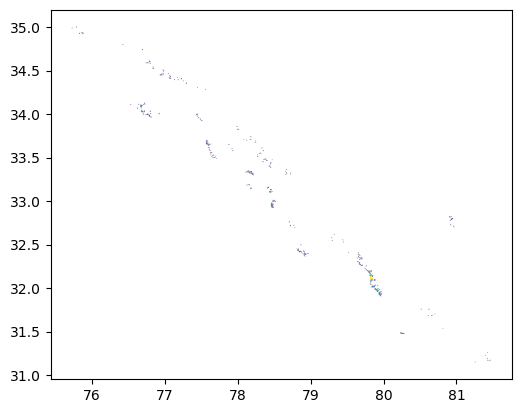

In [65]:
gdf2.plot('area')

In [66]:
# Reading in Suru glacier data for 1977
gdf3 = gpd.read_file('/Users/butler/Documents/hp/Ladakh/data/DATA_IN_GEOPACKAGE_FORMAT/GLACIER_OUTLINES/SURU_GLACIERS_2019.gpkg')

In [67]:
gdf3['area'] = gdf3.area

In [68]:
gdf3 = gdf3.to_crs(epsg=4326)
gdf3.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

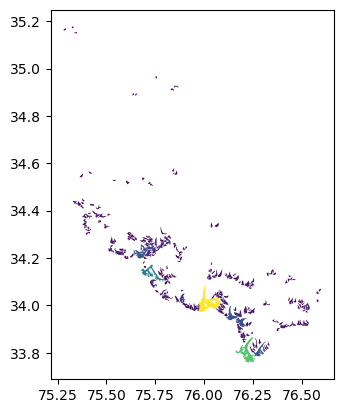

In [69]:
gdf3.plot('area')

In [70]:
# Reading in Tsokar glacier data for 1977
gdf4 = gpd.read_file('/Users/butler/Documents/hp/Ladakh/data/DATA_IN_GEOPACKAGE_FORMAT/GLACIER_OUTLINES/TSOKAR_GLACIERS_2019.gpkg')

In [71]:
gdf4['area'] = gdf4.area

In [72]:
gdf4 = gdf4.to_crs(epsg=4326)
gdf4.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

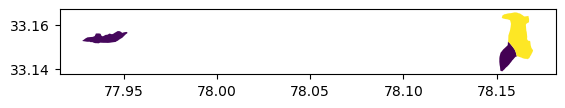

In [73]:
gdf4.plot('area')

In [74]:
# Reading in Tsomoriri glacier data for 1977
gdf5 = gpd.read_file('/Users/butler/Documents/hp/Ladakh/data/DATA_IN_GEOPACKAGE_FORMAT/GLACIER_OUTLINES/TSOMORIRI_GLACIERS_2019.gpkg')

In [75]:
gdf5['area'] = gdf5.area

In [76]:
gdf5 = gdf5.to_crs(epsg=4326)
gdf5.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

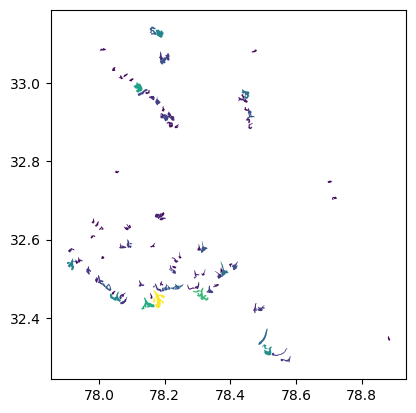

In [77]:
gdf5.plot('area')

In [78]:
# Reading in Zanskar glacier data for 1977
gdf6 = gpd.read_file('/Users/butler/Documents/hp/Ladakh/data/DATA_IN_GEOPACKAGE_FORMAT/GLACIER_OUTLINES/ZANSKAR_GLACIERS_2019.gpkg')

In [79]:
gdf6['area'] = gdf6.area

In [80]:
gdf6 = gdf6.to_crs(epsg=4326)
gdf6.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

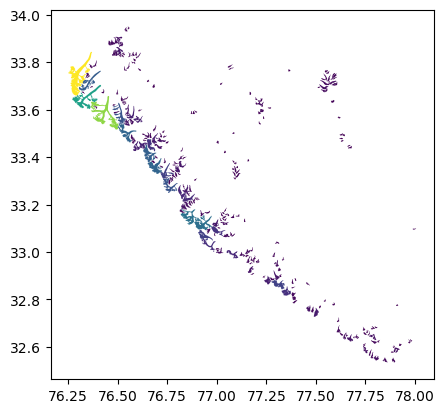

In [81]:
gdf6.plot('area')

In [82]:
# Concatenating all glacier data
gdf = pd.concat([gdf, gdf1, gdf2, gdf3, gdf4, gdf5, gdf6])

In [83]:
# Visualizing with glacier data from 1977
location = [34.0, 77.5]  # For ladakh regions just a point somehwere in the rectangle
m = folium.Map(location=location, zoom_start=7)

# Define the bounds of the rectangle. Format: [[lat_min, lon_min], [lat_max, lon_max]]
bounds = [[75, 36], [82, 32]]

# Add the rectangle to the map
folium.Rectangle(
    bounds=bounds,
    color='#ff7800',
    fill=True,
    fill_color='#ffff00',
    fill_opacity=0.2
).add_to(m)

# Plotting the glacier data
# Code from https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html
for _, r in gdf.iterrows():
    # Without simplifying the representation of part,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j)
    folium.Popup(r["JNUOAId"]).add_to(geo_j)
    geo_j.add_to(m)
    

# Add the raw image to the map
vis_params = {'bands': ['B4', 'B3', 'B2'], 'max': 0.3}
m.add_ee_layer(landsat, vis_params, 'Landsat Image')

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)